In [1]:
# Importing the required modules

In [2]:
!pip install catboost

     |████████████████████████████████| 76.3 MB 1.4 MB/s 


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import pickle
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (10,6)

/usr/local/lib/python3.7/dist-packages/sklearn/experimental/enable_hist_gradient_boosting.py:17: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  "Since version 1.0, "


In [4]:
# Importing the dataset
df = pd.read_csv('Cleaned_Soil.csv')

In [5]:
# Obtaining data specific to Anantapur

In [6]:
df = df[df['District'] == 'Srikakulam']
df.head()

,Unnamed: 0,Latitude,Longitude,District,Mandal,Village,SoilType,pH,EC,OC,P,K,Ca,Mg,S,Zn,B,Fe,Cu,Mn,NDVI,ARVI,EVI,GCI,NDWI,Crop
3039,3042,18.40,84.12,Srikakulam,Polaki,Ambeerupeta,Black soil,6.12,0.77,0.96,5.62,249.0,2399.0,809.0,28.89,0.95,1.30,53.30,5.31,44.57,0.488294,0.301503,1.720008,1.727273,-0.463415,Paddy/G.gram
3040,3043,18.40,84.12,Srikakulam,Polaki,Ambeerupeta,Black soil,7.55,0.15,0.53,5.09,86.0,1569.0,381.0,10.60,1.16,0.67,60.11,3.33,16.73,0.488294,0.301503,1.720008,1.727273,-0.463415,Paddy/G.gram
3041,3044,18.39,84.12,Srikakulam,Polaki,Ambeerupeta,Black soil,6.85,4.60,0.57,6.89,365.0,2299.0,1463.0,533.83,0.75,2.19,23.86,2.98,25.16,0.256113,0.089226,0.712878,0.919371,-0.314921,Paddy/G.gram
3042,3045,18.40,84.11,Srikakulam,Polaki,Ambeerupeta,Black soil,8.25,1.46,0.57,16.11,610.0,2226.0,608.0,128.32,2.02,1.30,9.95,2.21,7.01,0.475900,0.283605,1.483080,1.855305,-0.481234,Paddy/G.gram
3043,3046,18.39,84.12,Srikakulam,Polaki,Ambeerupeta,Black soil,6.70,0.69,0.63,6.28,111.0,1214.0,360.0,12.07,2.01,0.55,70.84,3.23,20.62,0.256113,0.089226,0.712878,0.919371,-0.314921,Paddy/G.gram


In [7]:
# Dropping unnecessary columns
df = df.drop(['Unnamed: 0', 'Latitude', 'Longitude', 'District', 'Mandal', 'Village', 'ARVI', 'EVI', 'NDVI', 'NDWI'], axis = 1)
df.describe()

,pH,EC,OC,P,K,Ca,Mg,S,Zn,B,Fe,Cu,Mn,GCI
count,446.000000,446.00000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000,446.000000
mean,6.966861,0.40213,0.460112,14.352175,151.515695,1051.047085,358.997758,30.967915,1.243520,0.968386,54.583901,2.295179,27.706256,1.678569
std,1.172992,0.71881,0.252593,22.835281,171.477724,743.139414,281.300611,70.984391,1.337936,0.622780,57.060332,1.493629,23.318972,0.864878
min,4.150000,0.02000,0.020000,0.450000,16.000000,46.000000,4.000000,0.100000,0.100000,0.100000,2.580000,0.110000,1.650000,-0.593511
25%,5.950000,0.13000,0.270000,4.630000,67.000000,615.000000,168.250000,5.635000,0.600000,0.502500,9.952500,1.180000,13.017500,1.086653
50%,6.980000,0.20000,0.420000,9.750000,104.500000,897.000000,285.000000,10.915000,0.905000,0.820000,33.410000,1.950000,20.425000,1.607654
75%,8.077500,0.36000,0.600000,17.642500,177.000000,1215.500000,462.750000,20.880000,1.500000,1.307500,84.510000,3.120000,34.407500,2.144766
max,9.040000,9.25000,2.260000,361.940000,2009.000000,5411.000000,1956.000000,648.540000,21.140000,3.660000,346.180000,9.520000,207.680000,4.645161


In [8]:
# Analysis of SoilType

In [9]:
df.SoilType.unique()

array(['Black soil', 'Red soil', 'Sandy loam', 'Saline soil', 'red soil',
       'red sandy', 'black soil', 'sandy loam', 'res soil', 'Red Soil',
       'Redsoil', 'Red sandy', 'Saline Soil'], dtype=object)

In [10]:
df['SoilType'] = df['SoilType'].replace(['Black soil', 'black soil'], 'Black Soil')
df['SoilType'] = df['SoilType'].replace(['Red soil', 'red soil', 'res soil', 'Redsoil'], 'Red Soil')
df['SoilType'] = df['SoilType'].replace(['Sandy loam', 'sandy loam'], 'Sandy Loam Soil')
df['SoilType'] = df['SoilType'].replace('Saline soil', 'Saline Soil')
df['SoilType'] = df['SoilType'].replace(['Red sandy', 'red sandy'], 'Red Sandy Soil')
df.SoilType.unique()

array(['Black Soil', 'Red Soil', 'Sandy Loam Soil', 'Saline Soil',
       'Red Sandy Soil'], dtype=object)

In [11]:
soilCount = dict(df['SoilType'].value_counts())
soilCount

{'Black Soil': 82,
 'Red Sandy Soil': 2,
 'Red Soil': 293,
 'Saline Soil': 10,
 'Sandy Loam Soil': 59}

<BarContainer object of 5 artists>

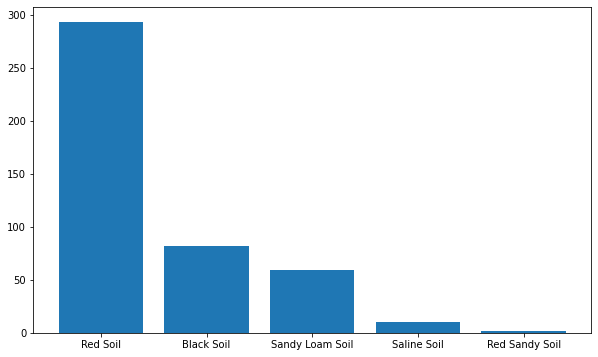

In [12]:
soilType = soilCount.keys()
soilCounts = soilCount.values()
plt.bar(soilType, soilCounts)

In [13]:
# Analysis of Crops grown 

In [14]:
df.Crop.unique()

array(['Paddy/G.gram', 'Cashew', 'Banana', 'banana/coconut',
       'Maize/paddy', 'coconut', 'Coconut', 'coconut/banana',
       'Paddy/Maize', 'Banana/coconut', 'cashew', 'Chilli Papaya',
       'Maize', 'banana', 'maize', 'paddy', 'Paddy Maize', 'Maize/Horti',
       'Cotton/Maize', 'paddy  ', 'Paddy', 'Paddy Sugercane',
       'Paddy/Ragi', 'Paddy/G.nut'], dtype=object)

In [15]:
df['Crop'].value_counts()

Paddy/G.gram       177
Paddy               59
Maize               40
Coconut             38
banana/coconut      36
Cashew              20
Banana/coconut      17
Banana              11
Maize/paddy          7
paddy                7
maize                5
Paddy/G.nut          5
Paddy Maize          4
Paddy Sugercane      3
Paddy/Ragi           3
banana               3
Cotton/Maize         3
Paddy/Maize          2
Maize/Horti          1
coconut              1
paddy                1
cashew               1
coconut/banana       1
Chilli Papaya        1
Name: Crop, dtype: int64

Paddy + GreenGram    177
Paddy                 78
Banana + Coconut      54
Maize                 49
Coconut               39
Cashew                21
Name: Crop, dtype: int64


<BarContainer object of 6 artists>

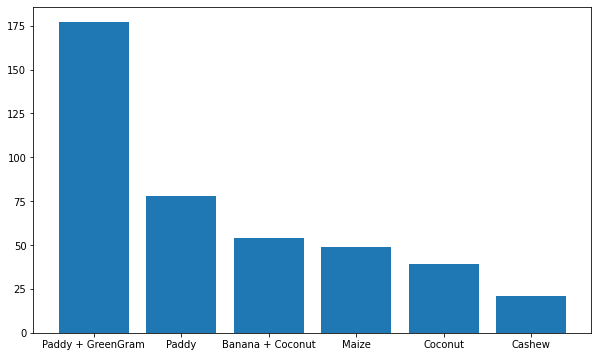

In [16]:
df['Crop'] = df['Crop'].replace(['Paddy/G.nut', 'Paddy/Ragi', 'Paddy Sugercane', 'paddy', 'paddy  '], 'Paddy')
df['Crop'] = df['Crop'].replace('Paddy/G.gram', 'Paddy + GreenGram')
df['Crop'] = df['Crop'].replace('cashew', 'Cashew')
df['Crop'] = df['Crop'].replace(['Maize/Horti', 'Cotton/Maize', 'maize'], 'Maize')
df['Crop'] = df['Crop'].replace(['Maize/paddy', 'Paddy/Maize', 'Paddy Maize'], 'Maize + Paddy')
df['Crop'] = df['Crop'].replace('banana', 'Banana')
df['Crop'] = df['Crop'].replace(['banana/coconut', 'coconut/banana', 'Banana/coconut'], 'Banana + Coconut')
df['Crop'] = df['Crop'].replace(['coconut', 'Coconut'], 'Coconut')
df = df[(df['Crop'] != 'Chilli Papaya') & (df['Crop'] != ' ') & (df['Crop'] != 'Banana') & (df['Crop'] != 'Maize + Paddy')]

print(df['Crop'].value_counts())
cropCount = dict(df['Crop'].value_counts())
cropType = cropCount.keys()
cropCounts = cropCount.values()
plt.bar(cropType, cropCounts)

In [17]:
# Getting rid of features that have a high correlation among one another

In [18]:
cor_matrix = df.corr()
cor_matrix

,pH,EC,OC,P,K,Ca,Mg,S,Zn,B,Fe,Cu,Mn,GCI
pH,1.000000,0.034492,-0.173944,0.139470,0.208921,0.102256,0.246669,0.002619,0.047751,0.385637,-0.700318,-0.378362,-0.355628,-0.064146
EC,0.034492,1.000000,0.292624,0.106245,0.278486,0.251430,0.333296,0.761586,0.080673,0.392758,-0.045499,0.175702,-0.082689,-0.030522
OC,-0.173944,0.292624,1.000000,0.425777,0.484595,0.521963,0.430736,0.247832,0.506473,0.467482,0.383583,0.688125,0.204073,0.079126
P,0.139470,0.106245,0.425777,1.000000,0.642979,0.146191,0.045911,0.071996,0.584419,0.228328,0.007922,0.059528,-0.047723,0.002172
K,0.208921,0.278486,0.484595,0.642979,1.000000,0.336618,0.289328,0.189886,0.408325,0.420456,-0.102922,0.161548,-0.021776,0.065818
Ca,0.102256,0.251430,0.521963,0.146191,0.336618,1.000000,0.848609,0.178897,0.193124,0.321091,0.128591,0.571778,0.136686,0.108389
Mg,0.246669,0.333296,0.430736,0.045911,0.289328,0.848609,1.000000,0.218454,0.058385,0.573423,-0.013518,0.508615,0.043985,0.049387
S,0.002619,0.761586,0.247832,0.071996,0.189886,0.178897,0.218454,1.000000,0.036845,0.418466,0.037770,0.168004,-0.087807,-0.079860
Zn,0.047751,0.080673,0.506473,0.584419,0.408325,0.193124,0.058385,0.036845,1.000000,0.140311,0.107751,0.177357,0.145566,0.171267
B,0.385637,0.392758,0.467482,0.228328,0.420456,0.321091,0.573423,0.418466,0.140311,1.000000,-0.149562,0.341294,-0.145286,-0.041743


In [19]:
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.5)]
print('Columns to be dropped : ', to_drop)


Columns to be dropped :  ['K', 'Ca', 'Mg', 'S', 'Zn', 'B', 'Cu']


In [20]:
df = df.drop(to_drop, axis = 1)
print('Columns taken into consideration : ', list(df.columns))

Columns taken into consideration :  ['SoilType', 'pH', 'EC', 'OC', 'P', 'Fe', 'Mn', 'GCI', 'Crop']


In [21]:
# Separating the dependent and independent variables
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

In [22]:
# Encoding SoilType as it is a categorical variable
X = pd.get_dummies(X, prefix='', prefix_sep='')
print(X.head(1))
print(y.head(1))
X = X.values
y = y.values

        pH    EC    OC  ...  Red Soil  Saline Soil  Sandy Loam Soil
3039  6.12  0.77  0.96  ...         0            0                0

[1 rows x 12 columns]
3039    Paddy + GreenGram
Name: Crop, dtype: object


In [23]:
# Standardizing the independent variables using Feature Scaling
sc1 = StandardScaler()
X[:, 0:7] = sc1.fit_transform(X[:, 0:7])

In [24]:
# Splitting the dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0, stratify=y)

# K-Nearest Neighbors Classifier

In [25]:
clf1 = KNeighborsClassifier(weights='distance')
clf1.fit(X_train, y_train)

KNeighborsClassifier(weights='distance')

In [26]:
y_test_pred = clf1.predict(X_test)
y_train_pred = clf1.predict(X_train)
AC1_train = accuracy_score(y_train, y_train_pred)
AC1_test = accuracy_score(y_test, y_test_pred)

In [27]:
print('Training Accuracy: ', AC1_train)
print('Testing Accuracy: ', AC1_test)

Training Accuracy:  1.0
Testing Accuracy:  0.6666666666666666


In [28]:
# k-Fold Cross Validation
accuracyList = cross_val_score(estimator = clf1, X = X_train, y = y_train, cv = 10)
print('Accuracy: {:.2f} %'.format(accuracyList.mean() * 100))
print('Standard Deviation: {:.2f} %'.format(accuracyList.std() * 100))

Accuracy: 66.82 %
Standard Deviation: 8.33 %


# Decision Tree Classifier

In [29]:
clf2 = DecisionTreeClassifier(random_state = 0)
clf2.fit(X_train, y_train)

DecisionTreeClassifier(random_state=0)

In [30]:
y_test_pred = clf2.predict(X_test)
y_train_pred = clf2.predict(X_train)
AC2_train = accuracy_score(y_train, y_train_pred)
AC2_test = accuracy_score(y_test, y_test_pred)

In [31]:
print('Training Accuracy: ', AC2_train)
print('Testing Accuracy: ', AC2_test)

Training Accuracy:  1.0
Testing Accuracy:  0.6


In [32]:
# k-Fold Cross Validation
accuracyList = cross_val_score(estimator = clf2, X = X_train, y = y_train, cv = 10)
print('Accuracy: {:.2f} %'.format(accuracyList.mean() * 100))
print('Standard Deviation: {:.2f} %'.format(accuracyList.std() * 100))

Accuracy: 63.61 %
Standard Deviation: 5.53 %


# Random Forest Classifier

In [33]:
clf3 = RandomForestClassifier(random_state = 0)
clf3.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [34]:
y_test_pred = clf3.predict(X_test)
y_train_pred = clf3.predict(X_train)
AC3_train = accuracy_score(y_train, y_train_pred)
AC3_test = accuracy_score(y_test, y_test_pred)

In [35]:
print('Training Accuracy: ', AC3_train)
print('Testing Accuracy: ', AC3_test)

Training Accuracy:  1.0
Testing Accuracy:  0.7333333333333333


In [36]:
# k-Fold Cross Validation
accuracyList = cross_val_score(estimator = clf3, X = X_train, y = y_train, cv = 10)
print('Accuracy: {:.2f} %'.format(accuracyList.mean() * 100))
print('Standard Deviation: {:.2f} %'.format(accuracyList.std() * 100))

Accuracy: 74.46 %
Standard Deviation: 6.52 %


In [37]:
pickle.dump(clf3, open('Srikakulam_model.pkl', 'wb'))
pickle.dump(sc1, open('Srikakulam_scaler.pkl', 'wb'))

# XGBoost

In [38]:
clf4 = HistGradientBoostingClassifier(random_state = 0)
clf4.fit(X_train, y_train)

HistGradientBoostingClassifier(random_state=0)

In [39]:
y_test_pred = clf4.predict(X_test)
y_train_pred = clf4.predict(X_train)
AC4_train = accuracy_score(y_train, y_train_pred)
AC4_test = accuracy_score(y_test, y_test_pred)

In [40]:
print('Training Accuracy: ', AC4_train)
print('Testing Accuracy: ', AC4_test)

Training Accuracy:  1.0
Testing Accuracy:  0.6952380952380952


In [41]:
# k-Fold Cross Validation
accuracyList = cross_val_score(estimator = clf4, X = X_train, y = y_train, cv = 10)

In [42]:
print('Accuracy: {:.2f} %'.format(accuracyList.mean() * 100))
print('Standard Deviation: {:.2f} %'.format(accuracyList.std() * 100))

Accuracy: 73.54 %
Standard Deviation: 6.48 %


# Multi-layer Perceptron Classifier

In [43]:
clf5 = MLPClassifier(random_state=0, learning_rate= 'adaptive')
clf5.fit(X_train, y_train)

MLPClassifier(learning_rate='adaptive', random_state=0)

In [44]:
y_test_pred = clf5.predict(X_test)
y_train_pred = clf5.predict(X_train)
AC5_train = accuracy_score(y_train, y_train_pred)
AC5_test = accuracy_score(y_test, y_test_pred)

In [45]:
print('Training Accuracy: ', AC5_train)
print('Testing Accuracy: ', AC5_test)

Training Accuracy:  0.7891373801916933
Testing Accuracy:  0.6761904761904762


In [46]:
# k-Fold Cross Validation
accuracyList = cross_val_score(estimator = clf5, X = X_train, y = y_train, cv = 10)
print('Accuracy: {:.2f} %'.format(accuracyList.mean() * 100))
print('Standard Deviation: {:.2f} %'.format(accuracyList.std() * 100))

Accuracy: 71.26 %
Standard Deviation: 5.63 %


# Catboost

In [47]:
from catboost import CatBoostClassifier, Pool, cv

model = CatBoostClassifier(iterations=100, depth=2, learning_rate=1, loss_function='MultiClass', verbose=True)
model.fit(X_train, y_train)

model.calc_feature_statistics(X_train, y_train, feature=1, plot=True)

train_data = Pool(data=X_train, label=y_train)
model.get_feature_importance(train_data)

#Cross-Validation
cv_dataset = Pool(data=X_train, label=y_train)
params = {"iterations": 100, "depth": 2, "loss_function": "MultiClass", "verbose": False}
scores = cv(cv_dataset, params, fold_count=5, plot="True")

model = CatBoostClassifier(loss_function='MultiClass')
grid = {'learning_rate': [0.03, 0.1], 'depth': [4, 6, 10]}
grid_search_result = model.grid_search(grid, X=X_train, y=y_train, cv=3, plot=True)

model.score(X_test, y_test)

# k-Fold Cross Validation
accuracyList = cross_val_score(estimator = model, X = X_train, y = y_train, cv = 10)
print('Accuracy: {:.2f} %'.format(accuracyList.mean() * 100))
print('Standard Deviation: {:.2f} %'.format(accuracyList.std() * 100))

0:	learn: 1.2495904	total: 47.7ms	remaining: 4.72s
1:	learn: 1.1370060	total: 49.5ms	remaining: 2.42s
2:	learn: 1.0392812	total: 50.6ms	remaining: 1.63s
3:	learn: 0.9217096	total: 51.8ms	remaining: 1.24s
4:	learn: 0.8844792	total: 52.9ms	remaining: 1s
5:	learn: 0.8649229	total: 53.9ms	remaining: 844ms
6:	learn: 0.8470370	total: 54.8ms	remaining: 728ms
7:	learn: 0.7719528	total: 55.8ms	remaining: 642ms
8:	learn: 0.7467286	total: 56.8ms	remaining: 574ms
9:	learn: 0.7381820	total: 57.7ms	remaining: 519ms
10:	learn: 0.7235750	total: 58.7ms	remaining: 475ms
11:	learn: 0.6635027	total: 59.7ms	remaining: 438ms
12:	learn: 0.6410762	total: 60.8ms	remaining: 407ms
13:	learn: 0.6190895	total: 61.8ms	remaining: 380ms
14:	learn: 0.6101380	total: 62.9ms	remaining: 356ms
15:	learn: 0.6072988	total: 63.9ms	remaining: 335ms
16:	learn: 0.5877087	total: 64.9ms	remaining: 317ms
17:	learn: 0.5570710	total: 67.4ms	remaining: 307ms
18:	learn: 0.5495191	total: 68.3ms	remaining: 291ms
19:	learn: 0.5246918	tota

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 1.019273527
bestIteration = 99

Training on fold [1/5]

bestTest = 1.038833815
bestIteration = 99

Training on fold [2/5]

bestTest = 1.032637574
bestIteration = 99

Training on fold [3/5]

bestTest = 1.040277701
bestIteration = 99

Training on fold [4/5]

bestTest = 0.9848511506
bestIteration = 99



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Streaming output truncated to the last 5000 lines.
2:	learn: 1.6939336	total: 6.55ms	remaining: 2.18s
3:	learn: 1.6631235	total: 8.94ms	remaining: 2.23s
4:	learn: 1.6318136	total: 11.2ms	remaining: 2.23s
5:	learn: 1.6043676	total: 13.2ms	remaining: 2.18s
6:	learn: 1.5781671	total: 15.2ms	remaining: 2.16s
7:	learn: 1.5510088	total: 17.4ms	remaining: 2.16s
8:	learn: 1.5286655	total: 20.3ms	remaining: 2.23s
9:	learn: 1.5108868	total: 23.6ms	remaining: 2.33s
10:	learn: 1.4897561	total: 33.9ms	remaining: 3.05s
11:	learn: 1.4677411	total: 36.2ms	remaining: 2.98s
12:	learn: 1.4459064	total: 38.2ms	remaining: 2.9s
13:	learn: 1.4262639	total: 40.6ms	remaining: 2.86s
14:	learn: 1.4080762	total: 42.8ms	remaining: 2.81s
15:	learn: 1.3900288	total: 46.3ms	remaining: 2.85s
16:	learn: 1.3724320	total: 48.3ms	remaining: 2.79s
17:	learn: 1.3542229	total: 50.1ms	remaining: 2.73s
18:	learn: 1.3381695	total: 52ms	remaining: 2.68s
19:	learn: 1.3188141	total: 54.2ms	remaining: 2.66s
20:	learn: 1.3038309	tot